# Coarse-graining tendency terms
CM2.6

In [11]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(15)
client = cluster.get_client()

In [12]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.c150b61115384e9498744560b3039c18/status,


In [116]:
client.close()
cluster.close()

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba, rho
import fastjmd95
import gcsfs
import gcm_filters
import xgcm
from typing import Annotated
#import gsw

In [2]:
from intake import open_catalog

url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml"
cat = open_catalog(url)
ds  = cat["GFDL_CM2_6_control_ocean"].to_dask()
surf_ds  = cat["GFDL_CM2_6_control_ocean_surface"].to_dask()
coord  = cat["GFDL_CM2_6_grid"].to_dask()

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [3]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

natl_surf = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf/natl_ocean_surf_tends.zarr'))
natl = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/natl_ocean.zarr'))
rho = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho.zarr'))

In [4]:
natl

<xarray.Dataset>
Dimensions:         (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
    geolat_t        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    lat             (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    lon             (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    st_ocean        float64 ...
  * time            (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
Data variables:
    NATL_cabbeling  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    NATL_rho_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    NATL_sss        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    NATL_sst        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [5]:
#create grid obj to interp dxu/dyu to xt/yt_ocean coordinates for dx_min_POP
import xgcm
grid = xgcm.Grid(coord, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'},
                        'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                        'Z': {'inner': 'st_ocean', 'outer': 'st_edges_ocean'} }, periodic=['X'])

In [6]:
wet_mask = coord.wet
dxt = coord.dxt
dyt = coord.dyt
#dxu = coord.dxu
#dyu = coord.dyu
area_t = coord.area_t
kappa = 10.0 #m^2/s

In [7]:
dxu_i = grid.interp(coord.dxu, ["X", "Y"])
dxu = dxu_i.assign_coords(coord.dxt.coords)
dyu_i = grid.interp(coord.dyu, ["X", "Y"])
dyu = dyu_i.assign_coords(coord.dyt.coords)

In [29]:
dx_min = min(dxt.where(wet_mask).min().values, dyt.where(wet_mask).min().values, 
                 dxu.where(wet_mask).min().values, dyu.where(wet_mask).min().values)
#dx_min = 1

## 100km 

In [30]:
specs_100km = {'filter_scale': 10000000, # 100km filter scale (written in cm to match model output)
         'filter_shape': gcm_filters.FilterShape.GAUSSIAN, 'dx_min': dx_min}

In [ ]:
filter_MOM5T_100km = gcm_filters.Filter(**specs_100km, 
                                        grid_type=gcm_filters.GridType.MOM5T,
                                        grid_vars={'wet_mask': wet_mask, 'dxt': dxt, 'dyt': dyt, 
                                                    'dxu': dxu, 'dyu': dyu, 'tarea': area_t})
filter_MOM5T_100km

In [ ]:
filtered100km_sst = filter_MOM5T_100km.apply(natl.NATL_sst, dims=['yt_ocean', 'xt_ocean'])
filtered100km_sss = filter_MOM5T_100km.apply(natl.NATL_sss, dims=['yt_ocean', 'xt_ocean'])
filtered100km_rho = filter_MOM5T_100km.apply(natl.NATL_rho_lap, dims=['yt_ocean', 'xt_ocean'])
filtered100km_cab = filter_MOM5T_100km.apply(natl.NATL_cabbeling, dims=['yt_ocean', 'xt_ocean'])

In [ ]:
sst_100km = filtered100km_sst[0].compute()
sss_100km = filtered100km_sss[0].compute()

rho_100km = filtered100km_rho[0].compute()
cab_100km = filtered100km_cab[0].compute()

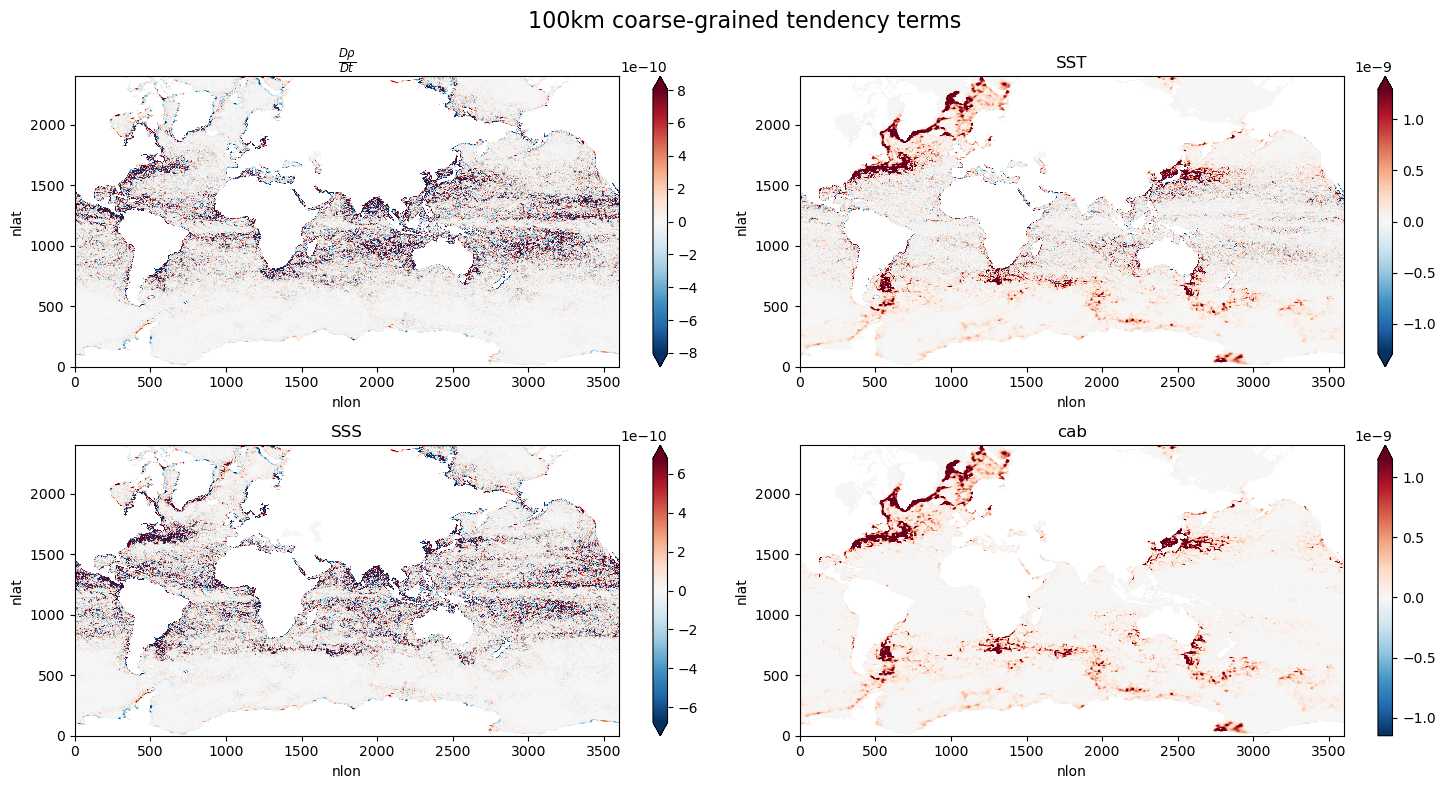

In [27]:
fig, ax = plt.subplots(2,2, figsize=(15,8))

rho_100km.plot(ax=ax[0,0], robust=True)
ax[0,0].set_title(r'$\frac{D \rho}{D t}$')

sst_100km.plot(ax=ax[0,1], robust=True)
ax[0,1].set_title('SST')

sss_100km.plot(ax=ax[1,0], robust=True)
ax[1,0].set_title('SSS')

cab_100km.plot(ax=ax[1,1], robust=True)
ax[1,1].set_title('cab')

plt.suptitle('100km coarse-grained tendency terms \n CM2.6', fontsize=16)
plt.tight_layout();

## Plot NATL Region

In [30]:
mask = cesm.REGION_MASK.reset_coords(drop=True)

In [31]:
#assign each region index value to basin name

caspian_sea = -14
black_sea = -13
#unknown = -1
#unknown = 0
southern_ocean = 1
pacific_ocean = 2
indian_ocean = 3
persian_gulf = 4
red_sea = 5
atlantic_ocean = 6
med_sea = 7
lab_sea = 8
norwegian_sea = 9
arctic_ocean = 10
hudson_bay = 11
baltic_sea = 12

In [32]:
#combine natl mask w/ norwegian and labrador seas
atl_mask = (mask>=atlantic_ocean) & (mask<=norwegian_sea) & (mask!=med_sea)

In [33]:
selection = dict(nlon=slice(0,1500), nlat=slice(200, None))

rho_gb = rho_100km.where(atl_mask).isel(**selection).groupby('time.month').mean('time')
sst_gb = sst_100km.where(atl_mask).isel(**selection).groupby('time.month').mean('time')
sss_gb = sss_100km.where(atl_mask).isel(**selection).groupby('time.month').mean('time')
cab_gb = cab_100km.where(atl_mask).isel(**selection).groupby('time.month').mean('time')

ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,8))

rho_gb.sel(month=3).plot(ax=ax[0,0], robust=True)
ax[0,0].set_title(r'$\frac{D \rho}{D t}$')

sst_gb.sel(month=3).plot(ax=ax[0,1], robust=True)
ax[0,1].set_title('SST')

sss_gb.sel(month=3).plot(ax=ax[1,0], robust=True)
ax[1,0].set_title('SSS')

cab_gb.sel(month=3).plot(ax=ax[1,1], robust=True)
ax[1,1].set_title('cab')

plt.suptitle('Mean March in NATL \n 100km coarse-grained tendency terms', fontsize=16)
plt.tight_layout();